# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

### Import modules

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
print(tf.__version__)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
from google.colab import drive
drive.mount('/content/gdrive')

1.13.1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [0]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='gdrive/My Drive/data/train'
testpath='gdrive/My Drive/data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=300 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


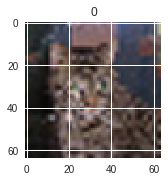

In [13]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

### The cnn_model_fn has to be defined here by the student

In [0]:
def cnn_model_fn(features, labels, mode):

    tf.random.set_random_seed(42)  
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  #the given images are 32*32 pixels, and have 3  channel
    x = features['x']
    
    input_layer =  tf.reshape(x,[-1,img_size, img_size, num_channels])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 32, 32, 3]
  # Output Tensor Shape: [batch_size, 32, 32, 32]
    c1 = tf.layers.conv2d(inputs=input_layer, activation=tf.nn.relu, filters=32,
                          kernel_size=[5,5], padding='VALID', strides=1, name="layer_conv1")
    
   # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 32, 32, 32]
  # Output Tensor Shape: [batch_size, 16, 16, 32]
    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[2,2], strides=2)
    
    
  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 16, 16, 32]
  # Output Tensor Shape: [batch_size, 16, 16, 64]
    c2 = tf.layers.conv2d(inputs=p1, activation=tf.nn.relu, filters=64,
                          kernel_size=[5,5], padding='VALID', strides=1, name="layer_conv2")
    
  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 16, 16, 64]
  # Output Tensor Shape: [batch_size, 5, 5, 64]
    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[2,2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 5, 5, 64]
  # Output Tensor Shape: [batch_size, 5 * 5 * 64]
    p2_flat = tf.reshape(p2, [-1, 5 * 5 * 64])
    #p2_flat = tf.contrib.layers.flatten(p2)

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 5 * 5 * 64]
  # Output Tensor Shape: [batch_size, 1024]
    fc1 = tf.layers.dense(
        inputs=p2_flat, units=1024, activation=tf.nn.relu, name = "layer_fc1")
    
    # Add dropout operation; 0.4 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=fc1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 32]
    logits = tf.layers.dense(inputs = fc1, units=32, name = "layer_fc2")
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
          loss=loss,
          global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)     
      

### Run the tensorflow model

This section will use the model defined by the student and run the training and evaluation step

In [15]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)

X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

# X_train = np.array((X_train/255.0),dtype=np.float64)
# X_test = np.array((X_test/255.0), dtype=np.float64)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="gdrive/My Drive/data/train/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"

tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=100,
                                                      num_epochs=None, shuffle=True)
#num_steps=[100,200,300]

pets_classifier.train(input_fn=train_input_fn, steps=300, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'gdrive/My Drive/data/train/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fee1d7fc940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSa